# Stock Price Prediction — Amazon (AMZN)

## Notebook 2 — Model Development (ARIMA, SARIMAX)

## Objective

The purpose of this notebook is to:

1. Prepare the modeling dataset using returns as the target variable.
2. Split the data chronologically into training and testing sets.
3. Build and evaluate time-series forecasting models:
   - ARIMA (baseline univariate model),
   - SARIMAX (including S&P 500 as an exogenous variable).
4. Compare model performance using out-of-sample evaluation metrics.
5. Analyze forecast behavior during normal and stress periods.

## Modeling Strategy

Based on the exploratory analysis in Notebook 1:

- Raw prices were found to be non-stationary.
- Returns were stationary (ADF test).
- Returns exhibit little autocorrelation, consistent with financial theory.
- Volatility clustering was detected in squared returns.
- Amazon shows a time-varying correlation with the S&P 500.

Therefore:

- We model **daily returns** rather than raw prices.
- ARIMA will serve as a baseline model.
- SARIMAX will incorporate S&P 500 returns as an external market factor.

## Important Note on Data Leakage

All train/test splits will be strictly chronological to preserve the time-series structure and avoid look-ahead bias.

## 1. Data Loading

We load the cleaned dataset produced in Notebook 1.

This dataset already includes:
- Adjusted Close price,
- Daily returns,
- S&P 500 returns (exogenous variable),
- Trading volume.

No additional transformations are performed at this stage to avoid data leakage.

In [1]:
import pandas as pd

data = pd.read_csv("../data/raw/amzn_sp500_clean.csv", index_col=0, parse_dates=True)

print(data.shape)
print(data.head())

(5032, 9)
            Adj Close   Close    High     Low    Open     Volume   Price  \
Date                                                                       
2005-01-04     2.1070  2.1070  2.1630  2.0750  2.1335  388370000  2.1070   
2005-01-05     2.0885  2.0885  2.1380  2.0780  2.0785  167084000  2.0885   
2005-01-06     2.0525  2.0525  2.1125  2.0450  2.0905  174018000  2.0525   
2005-01-07     2.1160  2.1160  2.1345  2.0580  2.0690  196732000  2.1160   
2005-01-10     2.0920  2.0920  2.1480  2.0855  2.0970  146958000  2.0920   

              Return  SP500_Return  
Date                                
2005-01-04 -0.053459     -0.011671  
2005-01-05 -0.008780     -0.003628  
2005-01-06 -0.017237      0.003506  
2005-01-07  0.030938     -0.001431  
2005-01-10 -0.011342      0.003423  


In [2]:
data.info()
data[["Return", "SP500_Return"]].describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5032 entries, 2005-01-04 to 2024-12-31
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Adj Close     5032 non-null   float64
 1   Close         5032 non-null   float64
 2   High          5032 non-null   float64
 3   Low           5032 non-null   float64
 4   Open          5032 non-null   float64
 5   Volume        5032 non-null   int64  
 6   Price         5032 non-null   float64
 7   Return        5032 non-null   float64
 8   SP500_Return  5032 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 393.1 KB


,Return,SP500_Return
count,5032.000000,5032.000000
mean,0.001195,0.000389
std,0.023881,0.012077
min,-0.218220,-0.119841
25%,-0.009875,-0.004085
50%,0.000648,0.000712
75%,0.012351,0.005721
max,0.269497,0.115800


## 2. Train–Test Split (Chronological)

In time-series forecasting, data must be split chronologically to preserve temporal ordering.

We define:

- Training set: 2005–2016
- Test set: 2017–2024  

This setup simulates a real forecasting scenario, where models are trained on historical data and evaluated on future unseen data.

No random shuffling is applied to avoid look-ahead bias.

### Structural Regimes Consideration

Financial markets are known to experience structural breaks and regime shifts (e.g., the 2008 financial crisis, the COVID-19 crash, and the 2022 monetary tightening cycle).  
While formal break tests are not conducted in this project, we acknowledge that model performance may vary across different market regimes.

For this reason, the dataset is split chronologically to simulate real-world forecasting conditions and to evaluate model robustness during both normal and stress periods.

In [3]:
split_date = "2017-01-01"

train = data.loc[data.index < split_date]
test = data.loc[data.index >= split_date]
# Limiter le test à 500 observations pour rolling OOS

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (3020, 9)
Test shape: (2012, 9)


The split date is set to January 1st, 2017.

This choice ensures that:

- The training set (2005–2016) includes multiple market regimes, such as the 2008 financial crisis and the subsequent recovery period.
- The test set (2017–2024) contains more recent and challenging environments, including the COVID-19 crash (2020) and the 2022 monetary tightening cycle.

This setup allows the model to be trained on diverse historical conditions while being evaluated on structurally different and more volatile recent periods, providing a realistic and rigorous out-of-sample assessment.

## 3. Baseline Model — ARIMA (Univariate)

We start with a univariate ARIMA model on **AMZN daily returns**.

ARIMA models the conditional mean dynamics of the series using:
- **AR (p)**: dependence on past returns,
- **I (d)**: differencing to ensure stationarity,
- **MA (q)**: dependence on past forecast errors.

Since returns were found to be stationary in Notebook 1 (ADF test), we set **d = 0** and focus on selecting **p** and **q**.

ARIMA will serve as a statistical baseline before introducing exogenous information with SARIMAX.

In [4]:
from statsmodels.tsa.arima.model import ARIMA

y_train = train["Return"]
y_test = test["Return"]

p, d, q = 1, 0, 1
arima_model = ARIMA(y_train, order = (p, d, q))
arima_result = arima_model.fit()

print(arima_result.summary())

arima_forecast = arima_result.get_forecast(steps=len(y_test))
arima_forecast = arima_forecast.predicted_mean

arima_forecast.index = y_test.index
arima_forecast = pd.Series(arima_forecast, index = y_test.index, name = "ARIMA_Forecast")
arima_forecast.head()   

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 3020
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6769.022
Date:                Sat, 28 Feb 2026   AIC                         -13530.045
Time:                        20:06:50   BIC                         -13505.993
Sample:                             0   HQIC                        -13521.396
                               - 3020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      2.576      0.010       0.000       0.002
ar.L1         -0.0915      2.132     -0.043      0.966      -4.270       4.087
ma.L1          0.0990      2.129      0.046      0.9

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2017-01-03    0.001106
2017-01-04    0.001270
2017-01-05    0.001255
2017-01-06    0.001257
2017-01-09    0.001256
Name: ARIMA_Forecast, dtype: float64

The ARIMA(1,0,1) model confirms that past returns do not significantly explain future returns, as AR and MA terms are not statistically significant.

Residual diagnostics indicate:
- No remaining autocorrelation (Ljung-Box test),
- Non-normal residuals (heavy tails),
- Presence of heteroskedasticity (volatility clustering).

These findings motivate extending the model by incorporating exogenous market information (S&P 500 returns) and potentially modeling conditional volatility.

## 4. Extended Model — SARIMAX (with S&P 500 as Exogenous Variable)

To incorporate broader market information, we extend the ARIMA model by including S&P 500 daily returns as an exogenous variable.

The rationale is that Amazon is part of the S&P 500 index, and its returns are likely influenced by overall market movements (systematic risk / beta effect).

The SARIMAX model allows us to estimate:

- AR and MA dynamics (if any),
- The impact of contemporaneous market returns,
- While preserving the time-series structure.

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX     

y_train = train["Return"]
y_test = test["Return"] 

X_train = train[["SP500_Return"]]
X_test = test[["SP500_Return"]]

In [6]:
X_train.isna().sum()

SP500_Return    0
dtype: int64

In [7]:
p, d, q = 1, 0, 1

sarimax_model = SARIMAX(
    y_train,
    exog = X_train,
    order = (p, d, q),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_result = sarimax_model.fit()

print(sarimax_result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41468D+00    |proj g|=  3.97124D-02

At iterate    5    f= -2.41471D+00    |proj g|=  3.46926D-01

At iterate   10    f= -2.41475D+00    |proj g|=  1.13336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   1.133D-03  -2.415D+00
  F =  -2.4147488544534945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                        

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


The SARIMAX results show that S&P 500 returns have a strong and statistically significant effect on Amazon returns (β ≈ 1.13, p < 0.001).

This confirms that Amazon’s return dynamics are largely driven by broader market movements (systematic risk).

Unlike the pure ARIMA model, AR and MA terms become statistically significant once the market effect is controlled for, suggesting residual short-term dynamics.

However, heteroskedasticity remains present, indicating volatility clustering that may require GARCH-type modeling.

# 5. Models Comparison

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_arima = np.sqrt(mean_squared_error(y_test, arima_forecast))
mae_arima = mean_absolute_error(y_test, arima_forecast)

sarimax_forecast = sarimax_result.get_forecast(steps=len(y_test), exog=X_test).predicted_mean
sarimax_forecast.index = y_test.index

rmse_sarimax = np.sqrt(mean_squared_error(y_test, sarimax_forecast))
mae_sarimax = mean_absolute_error(y_test, sarimax_forecast)

print("ARIMA RMSE:", rmse_arima)
print("ARIMA MAE :", mae_arima)
print("SARIMAX RMSE:", rmse_sarimax)
print("SARIMAX MAE :", mae_sarimax)

ARIMA RMSE: 0.020803697019797156
ARIMA MAE : 0.014575625091499336
SARIMAX RMSE: 0.01581373475431697
SARIMAX MAE : 0.010703661821320416


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


**Model Comparison**

Out-of-sample evaluation shows that SARIMAX significantly outperforms ARIMA.
- ARIMA RMSE: 0.0208
- SARIMAX RMSE: 0.0158

Including S&P 500 returns as an exogenous variable improves forecast accuracy by approximately 24%, confirming that market-wide movements provide predictive information for Amazon returns.

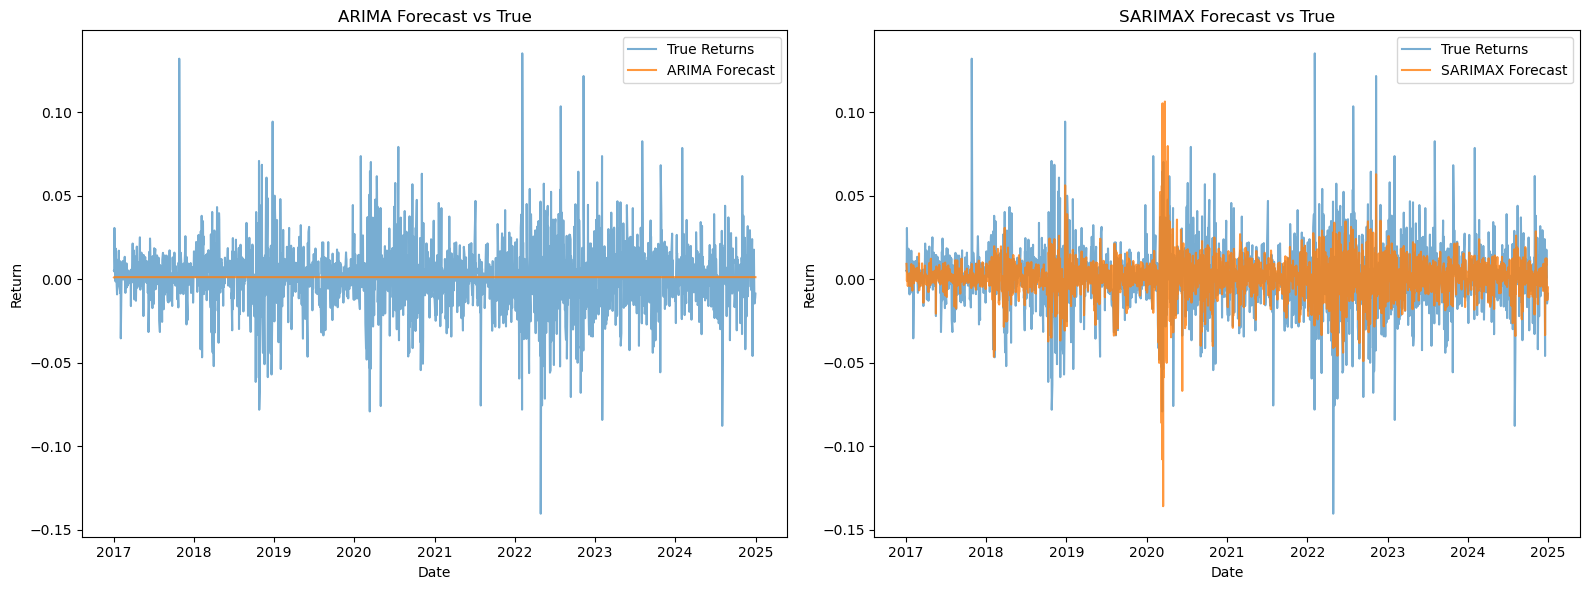

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16,6))

axes[0].plot(y_test.index, y_test, label="True Returns", alpha=0.6)
axes[0].plot(arima_forecast.index, arima_forecast, label="ARIMA Forecast", alpha=0.8)
axes[0].set_title("ARIMA Forecast vs True")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Return")
axes[0].legend()

axes[1].plot(y_test.index, y_test, label="True Returns", alpha=0.6)
axes[1].plot(sarimax_forecast.index, sarimax_forecast, label="SARIMAX Forecast", alpha=0.8)
axes[1].set_title("SARIMAX Forecast vs True")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Return")
axes[1].legend()

plt.tight_layout()
plt.show()

**Forecast Comparison**

Visual inspection confirms that ARIMA produces near-constant forecasts due to weak autocorrelation in returns. In contrast, SARIMAX captures market-driven fluctuations by incorporating S&P 500 returns as an exogenous variable.

Quantitatively, SARIMAX reduces out-of-sample RMSE by approximately 24%, demonstrating the predictive relevance of broader market movements.

In [10]:
# point de départ = dernier prix du train
last_train_price = data.loc[data.index < split_date, "Price"].iloc[-1]

price_pred_arima = []
price_pred_sarimax = []

price_arima = last_train_price
price_sarimax = last_train_price

for r_arima, r_sarimax in zip(arima_forecast, sarimax_forecast):
    
    price_arima = price_arima * (1 + r_arima)
    price_sarimax = price_sarimax * (1 + r_sarimax)
    
    price_pred_arima.append(price_arima)
    price_pred_sarimax.append(price_sarimax)

price_pred_arima = pd.Series(price_pred_arima, index=y_test.index)
price_pred_sarimax = pd.Series(price_pred_sarimax, index=y_test.index)

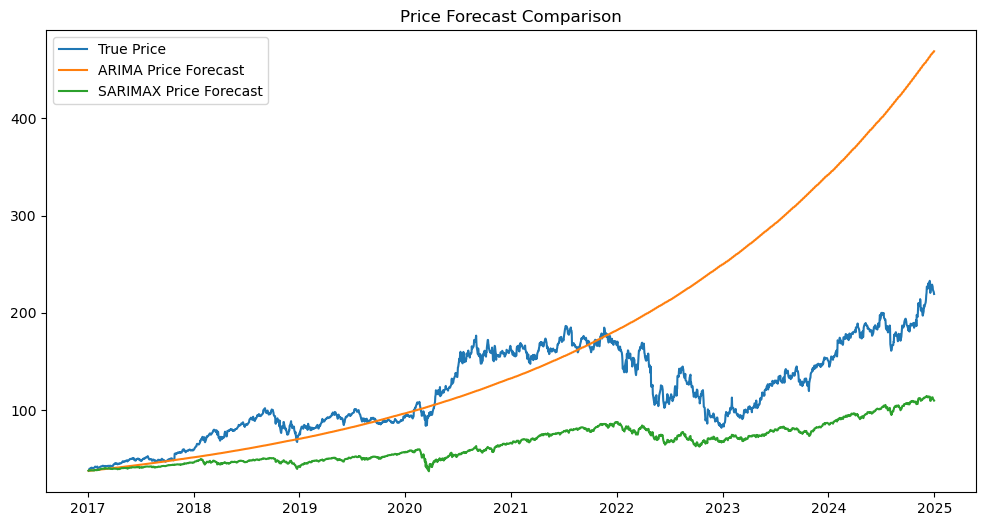

In [11]:
plt.figure(figsize=(12,6))
plt.plot(data.loc[data.index >= split_date, "Price"], label="True Price")
plt.plot(price_pred_arima, label="ARIMA Price Forecast")
plt.plot(price_pred_sarimax, label="SARIMAX Price Forecast")
plt.legend()
plt.title("Price Forecast Comparison")
plt.show()

The price reconstruction highlights the compounding nature of forecast errors. Even small biases in predicted returns accumulate exponentially over time, leading to large deviations from the true price path. This reinforces the well-documented difficulty of long-horizon price prediction in financial markets.

# 6. Volatility Modeling — GARCH(1,1)

While ARIMA and SARIMAX focus on modeling the conditional mean of returns, financial time series are primarily characterized by time-varying volatility rather than predictable average returns.

Previous analysis of squared returns revealed strong and persistent autocorrelation, indicating the presence of volatility clustering (a well-documented stylized fact in financial markets). Periods of high volatility tend to be followed by high volatility, and calm periods follow calm periods.

To capture this behavior, we implement a GARCH(1,1) model (Generalized Autoregressive Conditional Heteroskedasticity), which models the conditional variance of returns as a function of:
- past squared shocks (ARCH effect),
- past conditional variance (GARCH effect).

The model specification is:  
$$
r_t = \mu + \varepsilon_t
$$

$$
\varepsilon_t = \sigma_t z_t
$$

$$
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

Where:
- α captures short-term volatility shocks,
- β captures volatility persistence.

If α + β ≈ 1, volatility is highly persistent — a common feature of equity markets.

The objective of this section is to:
- Estimate conditional volatility dynamics,
- Forecast future volatility,
- Evaluate whether volatility is more predictable than returns

In [13]:
from arch import arch_model

garch_model = arch_model(
    y_train * 100, 
    vol = "Garch", 
    p=1, 
    q=1, 
    mean="Constant" 
)

garch_result = garch_model.fit(disp="off")

print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7029.51
Distribution:                  Normal   AIC:                           14067.0
Method:            Maximum Likelihood   BIC:                           14091.1
                                        No. Observations:                 3020
Date:                Sat, Feb 28 2026   Df Residuals:                     3019
Time:                        20:06:52   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1669  4.742e-02      3.519  4.327e-04 [7.394e-0

In [ ]:
returns = data["Return"] * 100

split_date = "2017-01-01"

train = returns[returns.index < split_date]
test  = returns[returns.index >= split_date]

rolling_vol = []

history = train.copy()

for t in range(len(test)):
    
    model = arch_model(history, vol="Garch", p=1, q=1, mean="Constant")
    res = model.fit(disp="off")
    
    forecast = res.forecast(horizon=1)
    vol = np.sqrt(forecast.variance.values[-1, 0])
    
    rolling_vol.append(vol)
    
    # on ajoute la vraie observation au dataset
    history = pd.concat([history, test.iloc[t:t+1]])

rolling_vol = pd.Series(rolling_vol, index=test.index)

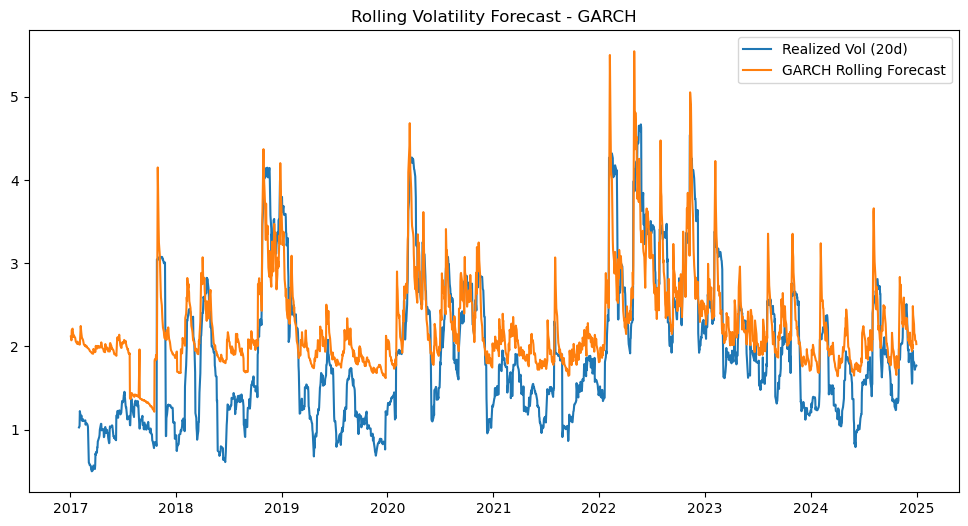

In [15]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test.rolling(20).std(), label="Realized Vol (20d)")
plt.plot(rolling_vol.index, rolling_vol, label="GARCH Rolling Forecast")
plt.legend()
plt.title("Rolling Volatility Forecast - GARCH")
plt.show()

Rolling GARCH Forecast

The rolling GARCH(1,1) forecast successfully captures time-varying volatility dynamics. The model responds to periods of market stress (e.g., 2020–2022) and adjusts downward during calmer regimes, confirming strong volatility persistence.

This result contrasts with return predictability, reinforcing the well-established financial insight that volatility is more predictable than returns.